In [95]:
import pandas as pd
import numpy as np
import datetime as dt
import geopandas as gpd
from shapely.geometry import Point
from functions import *
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error
import warnings
warnings.filterwarnings("ignore")

In [10]:
rent = pd.read_csv('Data/Raw/zillow_data.csv')
rent = rent[rent.City=='New York']
rent.drop(['RegionID', 'SizeRank', 'RegionType', 'StateName',
       'State', 'City', 'Metro', 'CountyName'], axis=1, inplace=True)


In [11]:
# group by year and get average

df = rent.melt(id_vars='RegionName',var_name='year',value_name='med_rent')
df['year'] = pd.to_datetime(df['year']).dt.year
df = df.groupby(['RegionName','year'])['med_rent'].mean().reset_index()  # get the average of that year for that zipcode
df.RegionName = df.RegionName.astype(str)
df['year'] = pd.to_datetime(df['year'].astype(str))



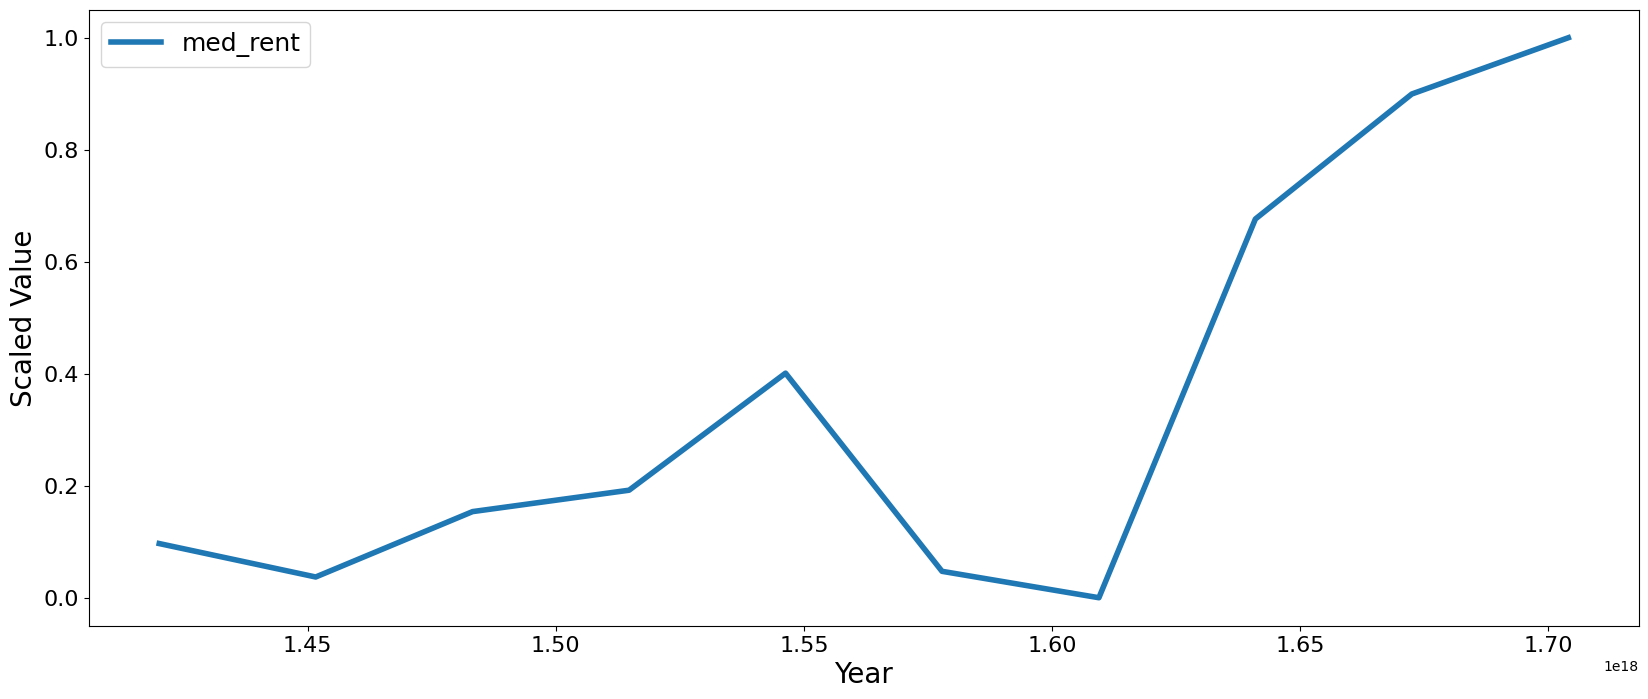

In [12]:
# check distribution of data before imputing 

group_by_yr = df.groupby('year')['med_rent'].mean().reset_index()
lineplot(group_by_yr, ['med_rent'])

### Add Missing years 

In [77]:
# expand date range to 2010

full_date_range = pd.date_range(start='2010-01-01', end='2024-01-01', freq='YS')
more_yrs = df.groupby('RegionName')[['year','med_rent']].apply(lambda x: x.set_index('year').reindex(full_date_range))
more_yrs = more_yrs.reset_index().rename(columns={'level_1':'year'})
more_yrs = more_yrs.sort_values(['RegionName','year'])
more_yrs

,RegionName,year,med_rent
0,10001,2010-01-01,NaN
1,10001,2011-01-01,NaN
2,10001,2012-01-01,NaN
3,10001,2013-01-01,NaN
4,10001,2014-01-01,NaN
...,...,...,...
2185,11694,2020-01-01,NaN
2186,11694,2021-01-01,NaN
2187,11694,2022-01-01,NaN
2188,11694,2023-01-01,NaN


## Linear Interpolation

In [53]:
def backfill_trend(df, column, exponential=False):
    non_null_values = df[column].dropna()
    if len(non_null_values) < 5:  # if there aren't enough observations to make a trend, will rely in spatial interpolation in postprocessing
        return df

    first_valid_index = non_null_values.index[0]
    valid_indices = np.arange(len(df))
    valid_values = df[column].values
    
    # Prepare data for linear regression
    known_indices = np.where(~np.isnan(valid_values))[0].reshape(-1, 1)
    known_values = valid_values[~np.isnan(valid_values)]

    model = LinearRegression()
    if exponential:
        model.fit(known_indices, np.log(known_values))  # take the log to make the exponential data linear
    else:
        model.fit(known_indices, known_values)
    
    missing_indices = np.where(np.isnan(valid_values))[0].reshape(-1, 1)
    predicted_values = model.predict(missing_indices)

    if exponential:
        predicted_values = np.exp(predicted_values)  # reshape the preds to make them exponentially shaped again
    
    # Assign backfilled values
    df[column].iloc[missing_indices.flatten()] = predicted_values
    
    return df

### Validate Backfill Function

In [94]:
val = more_yrs.copy()
val = val[val.year>'2014']

# split features and labels
labels = val[val.year>'2020']

# remove zip codes without enough data
to_drop = labels[labels.med_rent.isna()]['RegionName'].unique()
labels = labels[labels.RegionName.isin(to_drop)==False]
val = val[val.RegionName.isin(to_drop)==False]

# replace labels with nans 
val.loc[labels.index, 'med_rent'] = np.nan

# apply regression for the missing vals
val_exp = val.copy()
val_exp.rename(columns={'med_rent':'preds_exponential'}, inplace=True)
val_lin = val.copy()
val_lin.rename(columns={'med_rent':'preds_linear'}, inplace=True)
for zipcode in val_exp['RegionName'].unique():
    zip_df = val_exp[val_exp['RegionName']==zipcode]
    val_exp.drop(zip_df.index, inplace=True)
    zip_df = backfill_trend(zip_df, 'preds_exponential', exponential=True)
    val_exp = pd.concat([val_exp, zip_df])
for zipcode in val_lin['RegionName'].unique():
    zip_df = val_lin[val_lin['RegionName']==zipcode]
    val_lin.drop(zip_df.index, inplace=True)
    zip_df = backfill_trend(zip_df, 'preds_linear', exponential=False)
    val_lin = pd.concat([val_lin, zip_df])

# compare predictions with groundtruth
preds = pd.concat([val_exp, val_lin['preds_linear']], axis=1)
preds = preds.merge(labels, on=['RegionName','year'])
preds = preds[preds.year>'2020']
preds.drop(preds[preds.preds_linear.isnull()].index, inplace=True)

# compute baseline: mean rent annually
avg_rent = more_yrs.groupby('year')['med_rent'].mean()
avg_rent.name='annual_avg_rent'
preds = preds.merge(avg_rent, on='year')
preds

,RegionName,year,preds_exponential,preds_linear,med_rent,annual_avg_rent
0,10001,2021-01-01,4002.929184,4006.014522,4095.062903,2642.220480
1,10001,2022-01-01,3993.559446,3997.184848,4885.848383,2997.586674
2,10001,2023-01-01,3984.211640,3988.355175,5001.523985,3114.899929
3,10001,2024-01-01,3974.885714,3979.525501,5131.751891,3167.701829
4,10002,2021-01-01,3392.321134,3392.437927,3286.152608,2642.220480
...,...,...,...,...,...,...
283,11385,2024-01-01,2568.290003,2559.471169,3053.178462,3167.701829
284,11432,2021-01-01,1945.004635,1928.706445,1914.018286,2642.220480
285,11432,2022-01-01,2042.636379,2010.450860,2025.043963,2997.586674
286,11432,2023-01-01,2145.168859,2092.195275,2189.091778,3114.899929


In [96]:
preds.columns

Index(['RegionName', 'year', 'preds_exponential', 'preds_linear', 'med_rent',
       'annual_avg_rent'],
      dtype='object')

In [102]:
# calculate errors
cols = ['preds_exponential', 'preds_linear', 'annual_avg_rent']
for col in cols:
    print(f'RMSE {col}:\n   ',root_mean_squared_error(preds[col], preds['med_rent']))


RMSE preds_exponential:
    482.0821885654433
RMSE preds_linear:
    487.1504192377298
RMSE annual_avg_rent:
    856.9101048512991


### Apply backfill function

In [25]:
for zipcode in more_yrs['RegionName'].unique():
    zip_df = more_yrs[more_yrs['RegionName']==zipcode]
    more_yrs.drop(zip_df.index, inplace=True)
    zip_df = backfill_trend(zip_df, 'med_rent', exponential=True)
    more_yrs = pd.concat([more_yrs, zip_df])
more_yrs

/var/folders/w0/4r14_1sj0j7fl6nz7v1nwgkr0000gp/T/ipykernel_39823/2146751627.py:24: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df[column].iloc[missing_indices.flatten()] = predicted_values
/var/folders/w0/4r14_1sj0j7fl6nz7v1nwgkr0000gp/T/i

,RegionName,year,med_rent
0,10001,2010,3311.915852
1,10001,2011,3405.150436
2,10001,2012,3501.009690
3,10001,2013,3599.567502
4,10001,2014,3700.899841
...,...,...,...
2185,11694,2020,NaN
2186,11694,2021,NaN
2187,11694,2022,NaN
2188,11694,2023,NaN


### Match Zip Codes to CT's  

In [65]:
# get census tract to ZCTA conversion

# Load the shapefiles
tracts = gpd.read_file('Data/Raw/tracts2020_shapefile/nyct2020.shp')
tracts = tracts.to_crs(epsg = 4326)
zips = gpd.read_file('Data/Raw/zcta2020_shapefile/tl_2020_us_zcta520.shp')
zips = zips.to_crs(epsg = 4326)

# join files together on intersecion
mapping = gpd.sjoin(zips, tracts, how='inner', predicate="intersects")[['ZCTA5CE20','GEOID']]
mapping

# add census tract to main dataframe
merged = more_yrs.merge(mapping, left_on='RegionName', right_on='ZCTA5CE20', how='left').drop(['ZCTA5CE20'],axis=1)

In [66]:
# remove 2024
merged['year'] = pd.to_datetime(merged['year']).dt.year
dff = merged[merged.year.isin([2024])==False]
dff.sort_values('RegionName', inplace=True)
dff.drop_duplicates(['year','GEOID'], inplace=True)  # same zip code is matching with multiple CT's so we drop dupes randomly


/var/folders/w0/4r14_1sj0j7fl6nz7v1nwgkr0000gp/T/ipykernel_33977/2054869786.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dff.sort_values('RegionName', inplace=True)
/var/folders/w0/4r14_1sj0j7fl6nz7v1nwgkr0000gp/T/ipykernel_33977/2054869786.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dff.drop_duplicates(['year','GEOID'], inplace=True)  # same zip code is matching with multiple CT's so we drop dupes randomly


In [67]:
# adjust dtype
dff.drop('RegionName', axis=1, inplace=True)
dff['year'] = dff['year'].astype(str)
dff

/var/folders/w0/4r14_1sj0j7fl6nz7v1nwgkr0000gp/T/ipykernel_33977/3222166223.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dff.drop('RegionName', axis=1, inplace=True)
/var/folders/w0/4r14_1sj0j7fl6nz7v1nwgkr0000gp/T/ipykernel_33977/3222166223.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dff['year'] = dff['year'].astype(str)


,year,med_rent,GEOID
0,2010,3311.915852,36061005600
160,2018,4043.817517,36061011700
161,2018,4043.817517,36061008200
162,2019,4194.208708,36061005600
163,2019,4194.208708,36061005800
...,...,...,...
55282,2014,NaN,36081093800
55283,2014,NaN,36081094201
55284,2014,NaN,36081094202
55277,2014,NaN,36081092200


## Interpolate Missing Values

In [68]:
# fill more years in between
dff['year'] = pd.to_datetime(dff['year'].astype(str))
yearly = dff.groupby('GEOID')[['year','med_rent']].apply(lambda x: x.resample("YE", on='year').mean()).reset_index()
all_years = yearly.groupby('GEOID')[['year','med_rent']].apply(lambda x: x.resample("YE", on='year').mean()).apply(lambda x: x.interpolate(method='linear')).reset_index()
all_years['year'] = all_years['year'].dt.year
all_years

/var/folders/w0/4r14_1sj0j7fl6nz7v1nwgkr0000gp/T/ipykernel_33977/172777266.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dff['year'] = pd.to_datetime(dff['year'].astype(str))


,GEOID,year,med_rent
0,36005000100,2010,NaN
1,36005000100,2011,NaN
2,36005000100,2012,NaN
3,36005000100,2013,NaN
4,36005000100,2014,NaN
...,...,...,...
30235,36085032300,2019,1813.778960
30236,36085032300,2020,1788.639062
30237,36085032300,2021,1763.499164
30238,36085032300,2022,1880.070486


In [69]:
# all_years.to_parquet('Data/Cleaned/zillow_clean.parquet')